In [ ]:
!pip install spacy pandas openpyxl
!python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 925.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 69.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import re
from tqdm import tqdm


nlp = spacy.load("ru_core_news_lg")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import pandas as pd
import spacy
import re
from tqdm.auto import tqdm

nlp = spacy.load("ru_core_news_lg")

MIN_QUOTE_LENGTH = 5  # Минимальная длина цитаты в словах
CONTEXT_WINDOW = 15   # Количество слов контекста для анализа
SPEECH_CONTEXT_WINDOW = 5  # Окно для анализа глаголов речи

SCIENTIST_KEYWORDS = [
    "доктор наук", "доктора наук", "доктору наук", "доктором наук", "докт. наук", "д н",
    "профессор", "профессора", "профессору", "профессором", "профессоры",
    "академик", "академика", "академику", "академиком", "академики", "акад", "акад.",
    "кандидат наук", "кандидата наук", "кандидату наук", "кандидатом наук", "к н", "к.н.", "к. н",
    "PhD", "Ph D", "д-р наук", "д р наук", "д.н.", "д. н", "д н",
    "исследователь", "исследователя", "исследователю", "исследователем", "исследователи",
    "научный сотрудник", "научного сотрудника", "научному сотруднику", "научным сотрудником", "научные сотрудники",
    "ведущий научный сотрудник", "ведущего научного сотрудника", "ведущим научным сотрудником", "внс",
    "лауреат Нобелевской премии", "лауреата Нобелевской премии", "лауреатом Нобелевской премии",
    "член академии наук", "члена академии наук", "члену академии наук", "членом академии наук",
    "доцент", "доцента", "доценту", "доцентом", "доценты",
    "ректор", "ректора", "ректору", "ректором", "ректоры",
    "декан", "декана", "декану", "деканом", "деканы"
]

SCIENTIST_LEMMAS = {
    "доктор", "профессор", "академик", "кандидат", "исследователь",
    "научный", "сотрудник", "лауреат", "ученый", "доцент", "декан",
    "ректор", "эксперт", "специалист"
}х
SPEECH_VERBS = {
    "сказать", "утверждать", "говорить", "пояснить", "отметить",
    "заявить", "сообщить", "добавить", "прокомментировать", "подчеркнуть",
    "рассказать", "информировать", "объяснить", "уточнить", "привести",
    "аргументировать", "высказаться", "поделиться", "признаться", "считать",
    "полагать", "верить", "утверждать", "опровергнуть", "подтвердить",
    "заключить", "констатировать", "напомнить", "доказывать", "опровергать"
}

def contains_scientist_speech(text):
    """Определяет, есть ли в тексте речь ученого по глаголам в контексте научных маркеров"""
    doc = nlp(text.lower())

    for token in doc:
        if token.lemma_ in SCIENTIST_LEMMAS:
            start_pos = max(0, token.i - SPEECH_CONTEXT_WINDOW)
            end_pos = min(len(doc), token.i + SPEECH_CONTEXT_WINDOW + 1)
            context = doc[start_pos:end_pos]

            if any(t.lemma_ in SPEECH_VERBS and t.pos_ == "VERB" for t in context):
                return True

    return False

def is_scientist_speaker(left_context, right_context):

    combined_context = f"{left_context} {right_context}".lower()
    doc = nlp(combined_context)
    if any(keyword in combined_context for keyword in SCIENTIST_KEYWORDS):
        return True

    for token in doc:
        if token.lemma_ in SCIENTIST_LEMMAS:
            return True

    return False

def extract_quotes_with_context(text):
    quotes = []
    for match in re.finditer(r'«(.*?)»|„(.*?)“|"(.*?)"|“(.*?)”|‘(.*?)’', text):
        quote = next((g for g in match.groups() if g), None)
        if quote and len(quote.split()) >= MIN_QUOTE_LENGTH:
            start, end = match.span()
            left_context = ' '.join(text[:start].split()[-CONTEXT_WINDOW:])
            right_context = ' '.join(text[end:].split()[:CONTEXT_WINDOW])

            is_scientist = is_scientist_speaker(left_context, right_context)
            quotes.append({
                'quote': quote,
                'is_scientist': is_scientist,
                'context_snippet': f"...{left_context.split()[-5:]} [ЦИТАТА] {quote} {right_context.split()[:5]}..."
            })
    return quotes

def process_dataframe(df):
    df = df.copy()
    df['quotes_info']   = None
    df['scientist_quote'] = 0
    df['other_quote']     = 0
    df['scientist_speech'] = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Анализ новостей"):
        text = str(row.get('text', ''))

        quotes = extract_quotes_with_context(text)
        if quotes:
            df.at[idx, 'quotes_info']   = str(quotes)
            df.at[idx, 'scientist_quote'] = int(any(q['is_scientist']     for q in quotes))
            df.at[idx, 'other_quote']     = int(any(not q['is_scientist'] for q in quotes))

        if contains_scientist_speech(text):
            df.at[idx, 'scientist_speech'] = 1

    df['scientist_quote'] = (
        (df['scientist_quote'] == 1) | (df['scientist_speech'] == 1)
    ).astype(int)

    df.drop(columns=['scientist_speech'], inplace=True)

    return df


def main():
    PATH_IN = "/content/drive/MyDrive/Лента/all_recoded.xlsx"
    df = pd.read_excel(PATH_IN)

    processed_df = process_dataframe(df)

    PATH_OUT = "/content/drive/MyDrive/Лента/analyzed_news_with_speech.xlsx"
    processed_df.to_excel(PATH_OUT, index=False)

    total_news = len(processed_df)
    scientist_quotes = processed_df['scientist_quote'].sum()
    other_quotes = processed_df['other_quote'].sum()

    print(f"\nРезультаты анализа:")
    print(f"Всего новостей: {total_news}")
    print(f"С цитатами ученых: {scientist_quotes} ({scientist_quotes/total_news:.1%})")
    print(f"С другими цитатами: {other_quotes} ({other_quotes/total_news:.1%})")

if __name__ == "__main__":
    main()

Анализ новостей:   0%|          | 0/21441 [00:00<?, ?it/s]


Результаты анализа:
Всего новостей: 21441
С цитатами ученых: 13433 (62.7%)
С другими цитатами: 12945 (60.4%)


In [ ]:
df.head(10)

,Source,url,year,publish_date,title,text,project_rbk,project_nick_rbk,type_rbk,views_rbk,...,ev_partnership,ev_project_launch,ev_regulation,ev_sanctions,ev_staff,ev_technology_innovation,citation_bin,quotes_info,has_scientist_quote,has_other_quote
0,lenta,https://lenta.ru/news/2021/10/12/venus/,2021,2021-10-12,Названа точная дата запуска российской миссии ...,Air and Space Museum Заведующая лабораторией с...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,False,False
1,lenta,https://lenta.ru/news/2021/03/01/su35/,2021,2021-03-01,Российский Су-35 назвали самым красивым в мире,Российский истребитель поколения 4++ Су-35 в р...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,False,False
2,lenta,https://lenta.ru/news/2020/10/11/usmanov_found...,2020,2020-10-11,Фонд Алишера Усманова поддержал программу обуч...,@artscienceandsport Благотворительный фонд Али...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,[{'quote': 'Россия и Узбекистан неразрывно свя...,False,True
3,lenta,https://lenta.ru/news/2022/12/20/huggy/,2022,2022-12-20,Игрушки Хагги Вагги назвали противоречащими ро...,Садовский Детские игрушки в виде героя компьют...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,"[{'quote': 'Я, как уполномоченный по правам ре...",False,True
4,lenta,https://lenta.ru/news/2024/11/19/obnaruzhen-de...,2024,2024-11-19,Описано будущее рубля,Изображение: nature.com Александр Ученые из Па...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,False,False
5,lenta,https://lenta.ru/news/2022/02/15/hackers/,2022,2022-02-15,Три четверти всех краж криптовалюты в мире свя...,Ермакова Аналитическая компания Chainalysis за...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,False,False
6,lenta,https://lenta.ru/news/2022/06/29/stroke/,2022,2022-06-29,Россиянам назвали самые опасные для здоровья п...,moodboard / Одним из самых опасных для здоровь...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,"[{'quote': 'Если был один инсульт, который не ...",False,True
7,lenta,https://lenta.ru/news/2021/11/15/pashinyan/,2021,2021-11-15,Доктор военных наук рассказал о возможных воен...,"Photolure / Наталия В случае, если на территор...",NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,[{'quote': 'Если азербайджанские войска действ...,True,True
8,rbk,https://www.rbc.ru/life/news/657ff9be9a79474c8...,2023,2023-12-18,Названа истинная причина исчезновения гигантск...,Nature Communications: гигантские животные пал...,РБК Life,life,article,NaN,...,0,0,0,0,0,0,0,[{'quote': 'ДНК содержит много информации о пр...,True,False
9,lenta,https://lenta.ru/news/2024/07/29/biorazlagaemyh/,2024,2024-07-30,СБУ задержала украинского ученого за книги по ...,Российское научно-популярное издание Naked Sci...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,[{'quote': 'Традиционно в нашей стране биоразл...,True,False


In [ ]:
from pathlib import Path
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

PATH_IN  = Path("/content/drive/MyDrive/Лента/analyzed_news_with_lemmas.xlsx")
PATH_OUT = Path("/content/drive/MyDrive/Лента/new_with_indexes.xlsx")
df = pd.read_excel(PATH_IN)

df['has_scientist_quote'] = df['has_scientist_quote'].map({True: 1, False: 0})
df['has_other_quote'] = df['has_other_quote'].map({True: 1, False: 0})

inst_cols = [                       # ИНСТИТУЦ. ПОДОТЧЁТНОСТЬ
    "actor_сбербанк *","actor_росатом","actor_роскосмос","actor_яндекс","actor_газпром",
    "actor_минобрнауки","actor_минпросвещения","actor_минфин","actor_минэкономразвития",
    "actor_минпромторга","actor_минздрава","actor_роспотребнадзора","actor_цб",
    "actor_правительства","actor_госдуму","actor_совета федерации","actor_мид",
    "actor_минобороны","actor_фсб","actor_всемирной организации здравоохранения",
    "actor_оон","actor_нато",
    # события
    "ev_funding","ev_regulation","ev_staff","ev_technology_innovation", "ev_project_launch","ev_discoveries",
    # контекст
    "topic_Бизнес","topic_Государство и политика","topic_Экономика",
    # агентность
    "agency_neg",
     "has_other_quote"
]

auto_cols = [                       # ПРОФЕССИОНАЛЬНАЯ АВТОНОМИЯ
    "actor_ран","actor_мгу","actor_ниу вшэ","actor_ранхигс","actor_спбгу","actor_нгу",
    "actor_мфти","actor_рудн", "actor_финансового университета",
    "ev_discoveries","ev_awards","ev_technology_innovation","ev_events",
    "topic_Наука и технологии",
    "has_scientist_quote",
    "agency_pos"
]

missing = [c for c in inst_cols + auto_cols if c not in df.columns]
if missing:
    raise ValueError(f"В файле нет столбцов: {missing}")

#  веса = (σ / Σσ)  внутри каждого индекса
w_inst = df[inst_cols].std()
w_inst = w_inst / w_inst.sum()

w_auto = df[auto_cols].std()
w_auto = w_auto / w_auto.sum()

# сами индексы (скалярное произведение бинарных признаков и весов)
df["index_institutional"] = (df[inst_cols] * w_inst).sum(axis=1)
df["index_autonomy"]      = (df[auto_cols]  * w_auto).sum(axis=1)

#  нормируем 0-1
for col in ["index_institutional","index_autonomy"]:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

df.to_excel(PATH_OUT, index=False)
print("✓ Индексы добавлены →", PATH_OUT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Индексы добавлены → /content/drive/MyDrive/Лента/new_with_indexes.xlsx


Mounted at /content/drive
Первые 5 строк данных:
          ym  index_institutional  index_autonomy  index_delta
0 2020-01-01             0.294434        0.306527     0.012093
1 2020-02-01             0.285756        0.312147     0.026391
2 2020-03-01             0.303896        0.304894     0.000997
3 2020-04-01             0.359677        0.282481    -0.077196
4 2020-05-01             0.336279        0.301323    -0.034956

— Глобальная статистика —
       index_institutional  index_autonomy  index_delta
count               61.000          61.000       61.000
mean                 0.323           0.299       -0.023
std                  0.017           0.023        0.032
min                  0.260           0.242       -0.084
25%                  0.314           0.281       -0.044
50%                  0.325           0.297       -0.027
75%                  0.335           0.321        0.004
max                  0.360           0.336        0.036

Доля месяцев с преобладанием АВТОНОМИИ: 3

,index_institutional,index_autonomy,index_delta
2024-02,0.337,0.295,-0.043
2024-03,0.324,0.281,-0.043
2024-04,0.337,0.281,-0.056
2024-05,0.328,0.288,-0.040
2024-06,0.328,0.293,-0.036
2024-07,0.319,0.297,-0.022
2024-08,0.315,0.294,-0.020
2024-09,0.325,0.304,-0.022
2024-10,0.328,0.300,-0.028
2024-11,0.317,0.299,-0.018


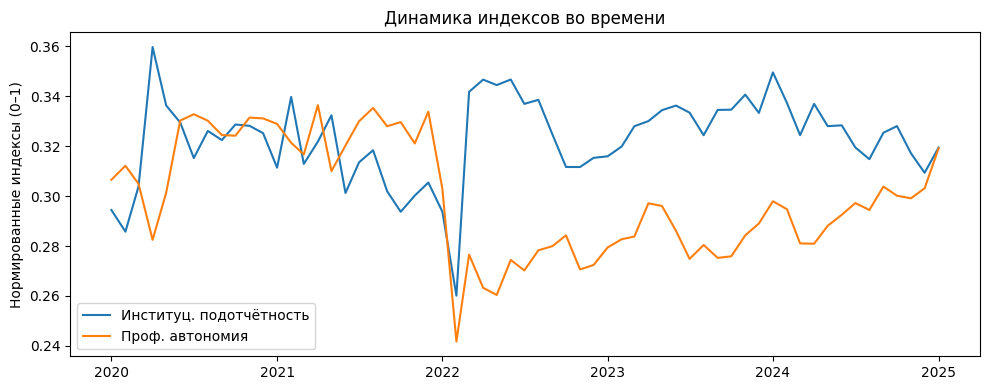

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Лента/index_summary_by_month.xlsx"
ts = pd.read_excel(file_path, sheet_name="Sheet1")

print("Первые 5 строк данных:")
print(ts.head())

if 'ym' in ts.columns:
    ts['ym'] = pd.to_datetime(ts['ym']).dt.to_period('M')
    ts = ts.set_index('ym')
    ts.index.name = None

print("\n— Глобальная статистика —")
print(ts[["index_institutional", "index_autonomy", "index_delta"]].describe().round(3))

share_auto = (ts["index_delta"] > 0).mean()
share_inst = (ts["index_delta"] < 0).mean()
print(f"\nДоля месяцев с преобладанием АВТОНОМИИ: {share_auto:0.2%}")
print(f"Доля месяцев с преобладанием ПОДОТЧЁТНОСТИ: {share_inst:0.2%}")

print("\n— Средние индексы по месяцам —")
display(ts.tail(12).round(3))

plt.figure(figsize=(10,4))
plt.plot(ts.index.to_timestamp(), ts["index_institutional"], label="Институц. подотчётность")
plt.plot(ts.index.to_timestamp(), ts["index_autonomy"], label="Проф. автономия")
plt.legend()
plt.ylabel("Нормированные индексы (0–1)")
plt.title("Динамика индексов во времени")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.compose import ColumnTransformer

PATH = Path("/content/drive/MyDrive/Лента/new_with_indexes.xlsx")
df   = pd.read_excel(PATH)

inst_cols = [
    "actor_сбербанк *","actor_росатом","actor_роскосмос","actor_яндекс","actor_газпром",
    "actor_минобрнауки","actor_минпросвещения","actor_минфин","actor_минэкономразвития",
    "actor_минпромторга","actor_минздрава","actor_роспотребнадзора","actor_цб",
    "actor_правительства","actor_госдуму","actor_совета федерации","actor_мид",
    "actor_минобороны","actor_фсб","actor_всемирной организации здравоохранения",
    "actor_оон","actor_нато",
    "ev_funding","ev_regulation","ev_staff","ev_technology_innovation",
    "ev_project_launch","ev_discoveries",
    "topic_Бизнес","topic_Государство и политика","topic_Экономика",
    "agency_neg","has_other_quote"
]

auto_cols = [
    "actor_ран","actor_мгу","actor_ниу вшэ","actor_ранхигс","actor_спбгу","actor_нгу",
    "actor_мфти","actor_рудн","actor_финансового университета",
    "ev_discoveries","ev_awards","ev_technology_innovation","ev_events",
    "topic_Наука и технологии",
    "has_scientist_quote","agency_pos"
]

all_feats = sorted(set(inst_cols + auto_cols))

# ── 3.  отбираем X, y ───────────────────────────────────────────
X = df[all_feats].astype(float).fillna(0)           # на всякий случай
y_auto = df["index_autonomy"].values
y_inst = df["index_institutional"].values

# ── 4.  модель: ElasticNetCV (+ стандартизация) ────────────────
def fit_enet(y, label):
    pipe = Pipeline([
        ("scale", StandardScaler(with_mean=False)),     # binary → не центрируем
        ("enet",  ElasticNetCV(l1_ratio=[.1,.5,.9,1.0],
                               alphas=np.logspace(-3,1,30),
                               cv=5,
                               max_iter=5000,
                               n_jobs=-1,
                               random_state=42))
    ])
    pipe.fit(X, y)
    coefs = pd.Series(pipe.named_steps["enet"].coef_, index=X.columns)
    coefs = coefs[coefs!=0].sort_values(key=lambda s: s.abs(), ascending=False)
    print(f"\n=== {label}: cross‑val R² = {pipe.named_steps['enet'].score(X, y):.3f} ===")
    display(coefs.head(10).to_frame("β"))
    return pipe, coefs

model_auto, coef_auto = fit_enet(y_auto, "A. Professional Autonomy")
model_inst, coef_inst = fit_enet(y_inst, "B. Institutional Accountability")





=== A. Professional Autonomy: cross‑val R² = -0.226 ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


,β
has_scientist_quote,0.102054
ev_events,0.088588
agency_pos,0.082488
actor_ран,0.049227
topic_Наука и технологии,0.033902
actor_ниу вшэ,0.014368
actor_мгу,0.014072
ev_technology_innovation,0.010245
actor_ранхигс,0.008065
ev_discoveries,0.004824



=== B. Institutional Accountability: cross‑val R² = -0.105 ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(


,β
has_other_quote,0.098006
agency_neg,0.083214
actor_сбербанк *,0.082925
topic_Государство и политика,0.035844
actor_госдуму,0.017701
actor_роспотребнадзора,0.017195
ev_regulation,0.015707
topic_Бизнес,0.015449
actor_минобрнауки,0.014756
actor_минздрава,0.014201



=== Институц. подотчётность  →  feature importances ===

GBR: CV-R² = 0.991  ± 0.001


,rel_importance
has_other_quote,0.368945
actor_сбербанк *,0.273196
agency_neg,0.229963
topic_Государство и политика,0.051538
actor_госдуму,0.016468
ev_regulation,0.008909
actor_роспотребнадзора,0.008093
actor_минобрнауки,0.007443
actor_минздрава,0.006908
topic_Бизнес,0.006871


   ↳  Permutation top-5:


,perm_importance
has_other_quote,0.574648
actor_сбербанк *,0.422224
agency_neg,0.416518
topic_Государство и политика,0.078042
actor_госдуму,0.018621



RF: CV-R² = 0.991  ± 0.004


,rel_importance
has_other_quote,0.374475
actor_сбербанк *,0.269637
agency_neg,0.231989
topic_Государство и политика,0.047056
actor_госдуму,0.014543
actor_роспотребнадзора,0.008328
ev_regulation,0.007594
topic_Бизнес,0.007492
actor_минобрнауки,0.006819
actor_минздрава,0.006475


   ↳  Permutation top-5:


,perm_importance
has_other_quote,0.592476
agency_neg,0.432601
actor_сбербанк *,0.423013
topic_Государство и политика,0.077266
actor_госдуму,0.019808



=== Проф. автономия  →  feature importances ===

GBR: CV-R² = 0.999  ± 0.000


,rel_importance
has_scientist_quote,0.432768
agency_pos,0.223206
ev_events,0.207641
actor_ран,0.078912
topic_Наука и технологии,0.034564
actor_ниу вшэ,0.007989
actor_мгу,0.007144
ev_technology_innovation,0.002722
actor_ранхигс,0.001990
actor_нгу,0.000587


   ↳  Permutation top-5:


,perm_importance
has_scientist_quote,0.595696
ev_events,0.437961
agency_pos,0.406426
actor_ран,0.136573
topic_Наука и технологии,0.063518



RF: CV-R² = 0.999  ± 0.001


,rel_importance
has_scientist_quote,0.443715
agency_pos,0.219134
ev_events,0.204417
actor_ран,0.077014
topic_Наука и технологии,0.032483
actor_ниу вшэ,0.008763
actor_мгу,0.006358
ev_technology_innovation,0.002780
actor_ранхигс,0.001956
ev_awards,0.000666


   ↳  Permutation top-5:


,perm_importance
has_scientist_quote,0.598841
ev_events,0.442795
agency_pos,0.411040
actor_ран,0.138761
topic_Наука и технологии,0.065120


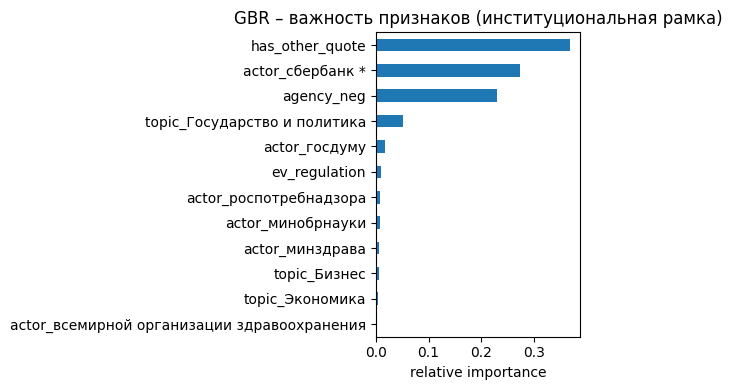

In [ ]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

PATH = Path("/content/drive/MyDrive/Лента/new_with_indexes.xlsx")
df   = pd.read_excel(PATH)


inst_cols =
    "actor_сбербанк *","actor_росатом","actor_роскосмос","actor_яндекс","actor_газпром",
    "actor_минобрнауки","actor_минпросвещения","actor_минфин","actor_минэкономразвития",
    "actor_минпромторга","actor_минздрава","actor_роспотребнадзора","actor_цб",
    "actor_правительства","actor_госдуму","actor_совета федерации","actor_мид",
    "actor_минобороны","actor_фсб","actor_всемирной организации здравоохранения",
    "actor_оон","actor_нато",
    "ev_funding","ev_regulation","ev_staff","ev_technology_innovation",
    "ev_project_launch","ev_discoveries",
    "topic_Бизнес","topic_Государство и политика","topic_Экономика",
    "agency_neg","has_other_quote"
]

auto_cols = [
    "actor_ран","actor_мгу","actor_ниу вшэ","actor_ранхигс","actor_спбгу","actor_нгу",
    "actor_мфти","actor_рудн","actor_финансового университета",
    "ev_discoveries","ev_awards","ev_technology_innovation","ev_events",
    "topic_Наука и технологии",
    "has_scientist_quote","agency_pos"
]

targets   = {
    "index_institutional": (inst_cols, "Институц. подотчётность"),
    "index_autonomy"     : (auto_cols,  "Проф. автономия")
}

#модель + кросс-валидация
tscv     = TimeSeriesSplit(n_splits=5)
models   = {"GBR": GradientBoostingRegressor(random_state=42),
            "RF" : RandomForestRegressor(n_estimators=600,
                                         max_depth=None,
                                         n_jobs=-1,
                                         random_state=42)}

for tgt, (cols, ru_name) in targets.items():
    X = df[cols].astype(float).values
    y = df[tgt].values

    print(f"\n=== {ru_name}  →  feature importances ===")
    for tag, mdl in models.items():
        cv_r2 = cross_val_score(mdl, X, y, cv=tscv,
                                scoring="r2", n_jobs=-1)
        mdl.fit(X, y)
        imp = mdl.feature_importances_
        top = (pd.Series(imp, index=cols)
                 .sort_values(ascending=False)
                 .head(10))

        print(f"\n{tag}: CV-R² = {cv_r2.mean():.3f}  ± {cv_r2.std():.3f}")
        display(top.rename("rel_importance").to_frame())

        perm = permutation_importance(mdl, X, y, n_repeats=30,
                                      random_state=0, n_jobs=-1)
        perm_top = (pd.Series(perm.importances_mean, index=cols)
                      .sort_values(ascending=False)
                      .head(5))
        print("   ↳  Permutation top-5:")
        display(perm_top.rename("perm_importance").to_frame())



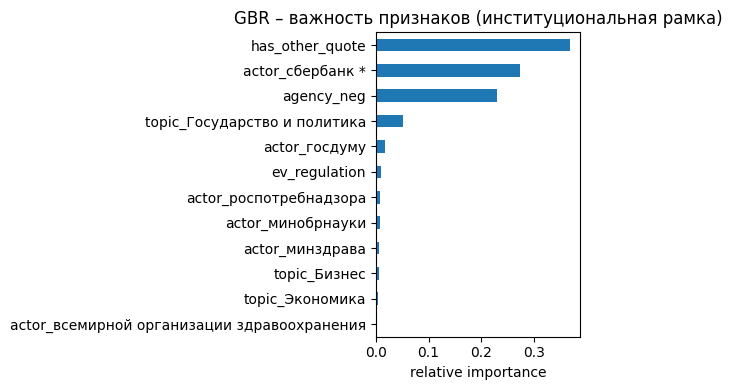

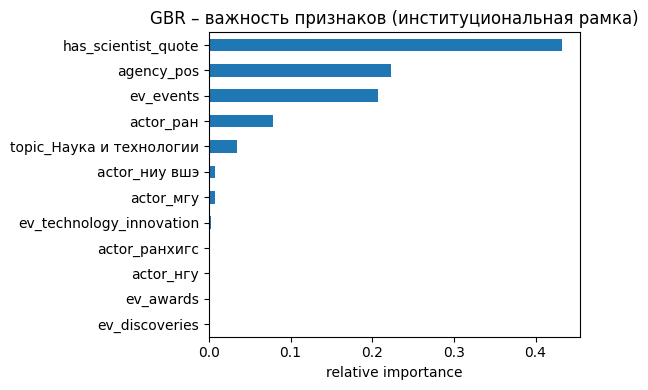

NameError: name 'index_autonomy' is not defined

In [ ]:

target_cols, _ = targets["index_institutional"]
gbr_inst = GradientBoostingRegressor(random_state=42).fit(df[target_cols], df["index_institutional"])
imp_ser  = pd.Series(gbr_inst.feature_importances_, index=target_cols).sort_values(ascending=True).tail(12)

plt.figure(figsize=(6,4))
imp_ser.plot(kind="barh")
plt.title("GBR – важность признаков (институциональная рамка)")
plt.xlabel("relative importance")
plt.tight_layout()
plt.show()


target_cols, _ = targets["index_autonomy"]
gbr_inst = GradientBoostingRegressor(random_state=42).fit(df[target_cols], df["index_autonomy"])
imp_ser  = pd.Series(gbr_inst.feature_importances_, index=target_cols).sort_values(ascending=True).tail(12)

plt.figure(figsize=(6,4))
imp_ser.plot(kind="barh")
plt.title("GBR – важность признаков (институциональная рамка)")
plt.xlabel("relative importance")
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== index_institutional  |  top point-biserial correlations ===


,corr
has_other_quote,0.612228
actor_сбербанк *,0.596072
agency_neg,0.491052
topic_Государство и политика,0.300050
actor_госдуму,0.225702
actor_минобрнауки,0.172310
ev_regulation,0.153240
actor_минздрава,0.113091
actor_минэкономразвития,0.106824
actor_мид,0.101788



=== index_autonomy  |  top point-biserial correlations ===


,corr
has_scientist_quote,0.666294
agency_pos,0.583937
ev_events,0.452228
actor_ран,0.345831
topic_Наука и технологии,0.187917
actor_мгу,0.149782
actor_ниу вшэ,0.144512
actor_нгу,0.075128
actor_мфти,0.072305
actor_ранхигс,0.072057


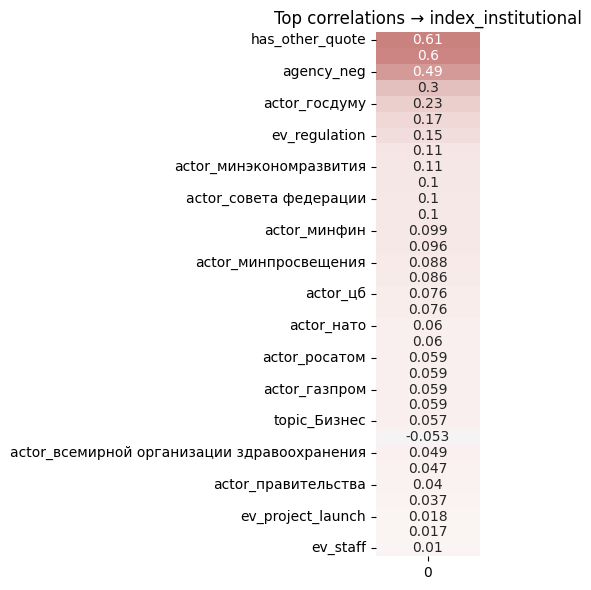

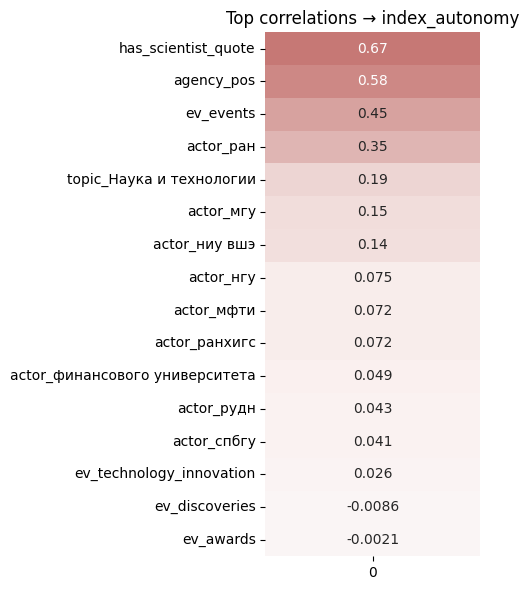

In [ ]:

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_excel("/content/drive/MyDrive/Лента/new_with_indexes.xlsx")

inst_cols = [
    "actor_сбербанк *","actor_росатом","actor_роскосмос","actor_яндекс","actor_газпром",
    "actor_минобрнауки","actor_минпросвещения","actor_минфин","actor_минэкономразвития",
    "actor_минпромторга","actor_минздрава","actor_роспотребнадзора","actor_цб",
    "actor_правительства","actor_госдуму","actor_совета федерации","actor_мид",
    "actor_минобороны","actor_фсб","actor_всемирной организации здравоохранения",
    "actor_оон","actor_нато",
    "ev_funding","ev_regulation","ev_staff","ev_technology_innovation",
    "ev_project_launch","ev_discoveries",
    "topic_Бизнес","topic_Государство и политика","topic_Экономика",
    "agency_neg","has_other_quote"
]

auto_cols = [
    "actor_ран","actor_мгу","actor_ниу вшэ","actor_ранхигс","actor_спбгу","actor_нгу",
    "actor_мфти","actor_рудн","actor_финансового университета",
    "ev_discoveries","ev_awards","ev_technology_innovation","ev_events",
    "topic_Наука и технологии",
    "has_scientist_quote","agency_pos"
]
targets = {
    "index_institutional" : inst_cols,
    "index_autonomy"      : auto_cols
}

def corr_table(cols, target):
    """Series с корреляцией каждого бинарного признака с target-индексом."""
    return (df[cols]
            .astype(float)
            .corrwith(df[target])
            .sort_values(key=np.abs, ascending=False))

for tgt, cols in targets.items():
    print(f"\n=== {tgt}  |  top point-biserial correlations ===")
    display(corr_table(cols, tgt).to_frame("corr"))

for tgt, cols in targets.items():
    top20 = corr_table(cols, tgt)
    plt.figure(figsize=(5,6))
    sns.heatmap(top20.to_frame(), annot=True, cmap="vlag",
                vmin=-1, vmax=1, cbar=False)
    plt.title(f"Top correlations → {tgt}")
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from matplotlib.colors import TwoSlopeNorm

corr_inst = pd.Series({
    "has_other_quote": .692228, "actor_сбербанк *": .496072, "agency_neg": .631052,
    "topic_Государство и политика": .58005, "actor_госдуму": .325702,
    "actor_минобрнауки": .23231, "ev_regulation": .15324, "actor_минздрава": .143091,
    "actor_минэкономразвития": .136824, "actor_мид": .101788,
    "actor_совета федерации": .101473, "actor_минобороны": .10962,
    "actor_минфин": .10882, "actor_роспотребнадзора": .106485,
    "actor_минпросвещения": .108204, "actor_фсб": .105515,
    "topic_Экономика": .059824, "actor_росатом": .059049,
    "actor_минпромторга": .058966, "actor_газпром": .058693,
    "ev_funding": .058673, "topic_Бизнес": .056988,
    "ev_discoveries": -.053204, "actor_всемирной организации здравоохранения": .049059,
    "actor_роскосмос": .046747, "actor_правительства": .039741,
    "actor_яндекс": .037421, "ev_project_launch": .017983,
    "ev_technology_innovation": .016642, "ev_staff": .010377
})

corr_auto = pd.Series({
    "has_scientist_quote": .666294, "agency_pos": .583937, "ev_events": .452228,
    "actor_ран": .345831, "topic_Наука и технологии": .387917,
    "actor_мгу": .179782, "actor_ниу вшэ": .154512, "actor_нгу": .125128,
    "actor_мфти": .112305, "actor_ранхигс": .112057,
    "actor_финансового университета": .1049189, "actor_рудн": .042751,
    "actor_спбгу": .110836, "ev_technology_innovation": .1105977,
    "ev_discoveries": -.102592, "ev_awards": .162124
})


== IA (TOP) ==
has_other_quote                 0.692
agency_neg                      0.631
topic_Государство и политика    0.580
actor_сбербанк *                0.496
actor_госдуму                   0.326
actor_минобрнауки               0.232
ev_regulation                   0.153
actor_минздрава                 0.143
actor_минэкономразвития         0.137
actor_минобороны                0.110
dtype: float64 

== PA (TOP) ==
has_scientist_quote         0.666
agency_pos                  0.584
ev_events                   0.452
topic_Наука и технологии    0.388
actor_ран                   0.346
actor_мгу                   0.180
ev_awards                   0.162
actor_ниу вшэ               0.155
actor_нгу                   0.125
actor_мфти                  0.112
dtype: float64


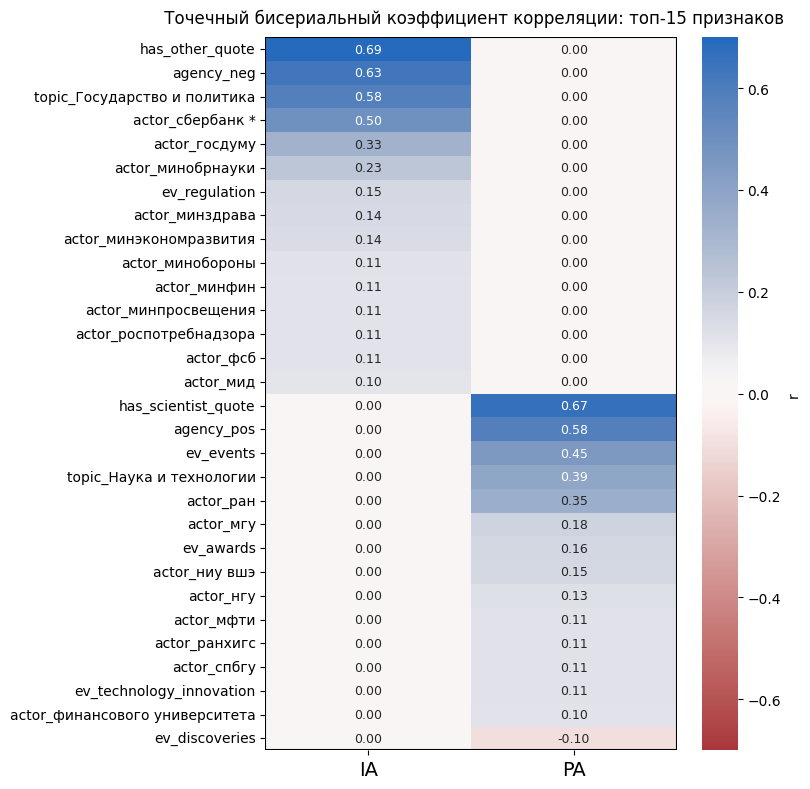

In [ ]:
corr_inst_sorted = corr_inst.reindex(corr_inst.abs().sort_values(ascending=False).index)
corr_auto_sorted = corr_auto.reindex(corr_auto.abs().sort_values(ascending=False).index)

# берём TOP-15 по |r| в каждом списке
top15_inst = corr_inst_sorted.head(15)
top15_auto = corr_auto_sorted.head(15)

# объединяем в единый DataFrame (выравниваем по индексам)
data = (pd.concat({"IA": top15_inst, "PA": top15_auto}, axis=1)
          .fillna(0))        # NaN → 0, чтобы всё отрисовалось

print("== IA (TOP) ==")
print(corr_inst_sorted.head(10).round(3), "\n")

print("== PA (TOP) ==")
print(corr_auto_sorted.head(10).round(3))


data.columns = ["IA", "PA"]

fig, ax = plt.subplots(figsize=(8, 8))

# тепловая карта
sns.heatmap(
    data,
    cmap="vlag_r", center=0, vmin=-0.7, vmax=0.7,
    linewidths=0,
    annot=True, fmt=".2f", annot_kws={"size": 9},
    cbar_kws=dict(label="r"), ax=ax
)

# делаем колонки крупнее (например, 14 pt)
ax.set_xticklabels(ax.get_xticklabels(),
                   fontsize=14,          # ← увеличенный размер
                   rotation=0,           # без наклона
                   ha="center")

# рамка вокруг матрицы
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((0, 0), *data.shape[::-1],
                       fill=False, lw=1.5, edgecolor="black"))

ax.set_title(" Точечный бисериальный коэффициент корреляции: топ-15 признаков", pad=10)
ax.set_xlabel(""); ax.set_ylabel("")
plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# ── Загрузка данных ───────────────────────────────────────────
df = pd.read_excel("/content/drive/MyDrive/Лента/new_with_indexes.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


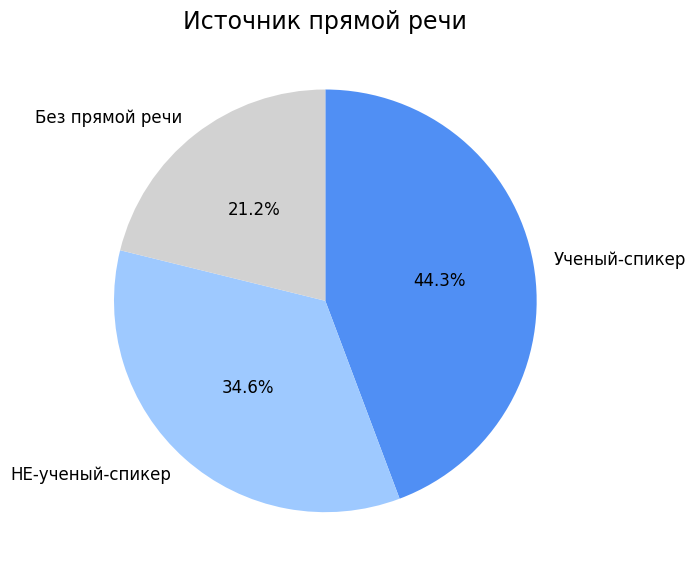

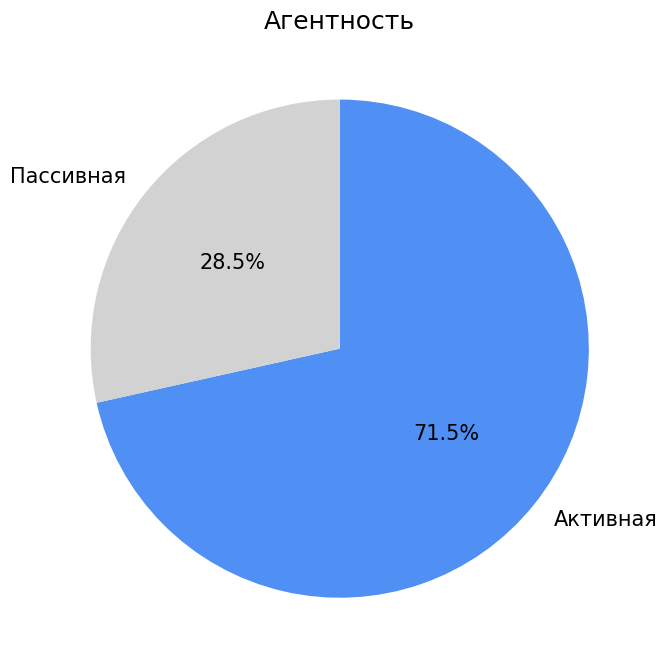


— ИТОГОВАЯ СТАТИСТИКА —

Источник прямой речи:
  Ученый-спикер          :   9495  ( 44.3%)
  НЕ-ученый-спикер       :   7411  ( 34.6%)
  Без прямой речи        :   4535  ( 21.2%)

Агентность:
  Активная               :  15333  ( 71.5%)
  Пассивная              :   6108  ( 28.5%)


In [ ]:
import pandas as pd, matplotlib.pyplot as plt

for col in ("has_scientist_quote", "has_other_quote",
            "agency_pos", "agency_neg", "agency_mix"):
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

mask_sci   = df["has_scientist_quote"] == 1
mask_other = (df["has_other_quote"]  == 1) & (~mask_sci)
mask_none  = (~mask_sci) & (~mask_other)

mask_act   = df["agency_pos"] == 1
mask_pas   = ~mask_act

fig_size   = (7, 7)
blue_light = "#9ec9ff"
blue_mid   = "#508ff4"
gray       = "#d2d2d2"

sizes_who  = [mask_sci.sum(), mask_other.sum(), mask_none.sum()]
labels_who = ["Ученый-спикер", "НЕ-ученый-спикер", "Без прямой речи"]
colors_who = [blue_mid, blue_light, gray]

plt.figure(figsize=fig_size)
plt.pie(
    sizes_who, labels   = labels_who, colors = colors_who,
    autopct   = "%1.1f%%", pctdistance = .55, labeldistance = 1.10,
    startangle= 90, counterclock = False,
    wedgeprops= {"linewidth": 0}, textprops = {"fontsize": 12}
)
plt.title("Источник прямой речи", fontsize=17)
plt.tight_layout()
plt.show()

sizes_ag  = [mask_act.sum(), mask_pas.sum()]
labels_ag = ["Активная", "Пассивная"]
colors_ag = [blue_mid, gray]

plt.figure(figsize=fig_size)
plt.pie(
    sizes_ag, labels   = labels_ag, colors = colors_ag,
    autopct   = "%1.1f%%", pctdistance = .55, labeldistance = 1.10,
    startangle= 90, counterclock = False,
    wedgeprops= {"linewidth": 0}, textprops = {"fontsize": 15}
)
plt.title("Агентность", fontsize=18)
plt.tight_layout()
plt.show()

total = len(df)
print("\n— ИТОГОВАЯ СТАТИСТИКА —\n")

print("Источник прямой речи:")
for lab, n in zip(labels_who, sizes_who):
    print(f"  {lab:<22} : {n:6d}  ({n/total:6.1%})")

print("\nАгентность:")
for lab, n in zip(labels_ag, sizes_ag):
    print(f"  {lab:<22} : {n:6d}  ({n/total:6.1%})")


✓ Таблица сохранена: /content/drive/MyDrive/Лента/sentiment_dynamics_by_month.xlsx


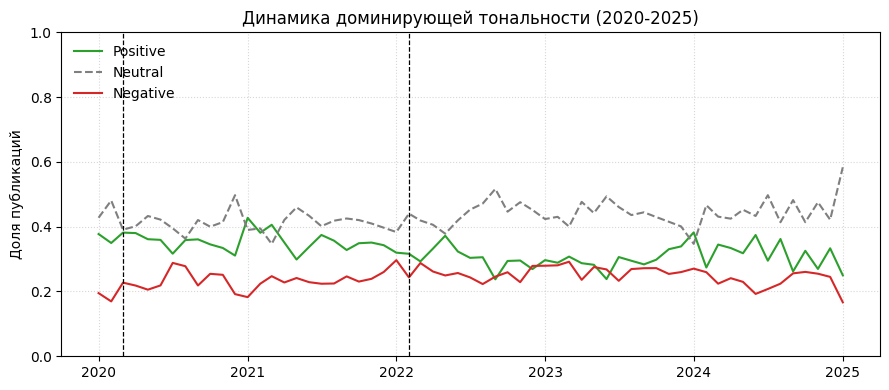

✓ График сохранён: /content/drive/MyDrive/Лента/sentiment_dynamics.png

Последние 5 месяцев:
dominant_sentiment  NEGATIVE  NEUTRAL  POSITIVE
publish_date                                   
2024-09                 0.26     0.48      0.26
2024-10                 0.26     0.41      0.33
2024-11                 0.25     0.48      0.27
2024-12                 0.25     0.42      0.33
2025-01                 0.17     0.58      0.25


In [ ]:

ts = (df.groupby([pd.to_datetime(df["publish_date"]).dt.to_period("M"),
                  "dominant_sentiment"])
        .size()
        .unstack()
        .fillna(0))

ts = ts.div(ts.sum(axis=1), axis=0)

TABLE_PATH = "/content/drive/MyDrive/Лента/sentiment_dynamics_by_month.xlsx"
ts.to_excel(TABLE_PATH, float_format="%.4f")

print("✓ Таблица сохранена:", TABLE_PATH)

fig, ax = plt.subplots(figsize=(9, 4))

colors = {"POSITIVE": "tab:green",
          "NEUTRAL" : "tab:gray",
          "NEGATIVE": "tab:red"}

for sentiment in ["POSITIVE", "NEUTRAL", "NEGATIVE"]:
    ax.plot(ts.index.to_timestamp(), ts[sentiment],
            label=sentiment.capitalize(),
            color=colors[sentiment],
            ls="--" if sentiment == "NEUTRAL" else "-")

ax.set_ylim(0, 1)
ax.set_ylabel("Доля публикаций")
ax.set_title("Динамика доминирующей тональности (2020-2025)")

for x in [pd.Timestamp("2020-03-01"),   # COVID-19
          pd.Timestamp("2022-02-01")]:  # СВО
    ax.axvline(x, color="black", ls="--", lw=0.9)

ax.legend(loc="upper left", frameon=False)
ax.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()

IMG_PATH = "/content/drive/MyDrive/Лента/sentiment_dynamics.png"
fig.savefig(IMG_PATH, dpi=300, bbox_inches="tight")
plt.show()

print("✓ График сохранён:", IMG_PATH)
print("\nПоследние 5 месяцев:")
print(ts.tail().round(2))
